# Homework 5
## Collin Dabbieri

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
import sys
sys.path.append('/Users/dabbiecm/Documents/ccd-reduction-and-photometry-guide/notebooks/')
from convenience_functions import show_image
from overscan_subtraction import overscan_subtraction
from flat_reduction import scaling
from flat_reduction import sigma_clip
from flat_reduction import weighted_mean


In [71]:
########### USER DEFINED VALUES #######################
imagedir='/Users/dabbiecm/Imaging/'
flatnames=['a'+str(i).zfill(3)+'.fits' for i in [5,6,7,8,9,10]]
sciencenames=['a'+str(i).zfill(3)+'.fits' for i in range(11,63)]
biasnames=['a'+str(i).zfill(3)+'.fits' for i in range(93,112)]

flat_vmin=25000            # minimum level for plotting flat values
flat_vmax=45000            # maximum level for plotting flat values
bias_vmin=620              # minimum level for plotting bias and dark values
bias_vmax=700              # maximum level for plotting bias and dark values
flat_scaled_vmin=0.75
flat_scaled_vmax=1.25

left_overscan=[0,54]       # columns of overscan region on left side (indexed from 0) (last column not included)
right_overscan=[2100,2199] # columns of overscan region on right side (indexed from 0) (last column not included)
trimsec=[54,2100]          # columns of image (last column not included, for pythonic array indexing)

num_flats=len(flatnames)
num_science=len(sciencenames)

num_rows=2048
num_columns_all=2200
num_columns_trim=2046

overscan_combine='mean'
fit_type='polynomial'
fit_deg=4

## 1. 
Examine your individual flat field images for the V filter. Are there significant artifacts? How might we combine the frames into a master flat field frame to get rid of these artifacts? Compare the average light levels in your V flats and say how this will impact your combine strategy (hint: you will want to scale your flat field images to a common level, and then combine using some weighting to account for the fact that some flats have higher signal than others–it world be inappropriate to give them all equal weight). After scaling to a common mean, discuss the advantages and disadvantages of making a master flat field image from:
 - A straight average of all V flat frames
 - A straight median of all V flat frames
 - An average where outlier pixels are rejected if they are more than 3σ from the mean
 - An average where outlier pixels are rejected and the weighted mean is obtained by weighting each image by the mean counts in the original image. This way, bright flats field exposures with higher count rates are given more weight than flats with low light levels.
 
Which of these strategies, if any, is the best? Or is some combination the right approach? Show plots and metrics like RMS to defend your conclusions.

### First let's overscan subtract and trim all flat images

In [4]:
flat_images_ot=np.zeros(shape=(num_flats,num_rows,num_columns_trim))
count=0
for name in flatnames:
    data=fits.open(imagedir+name)[0].data
    flat_o,AIC=overscan_subtraction(data,right_overscan,trimsec,overscan_combine,fit_type,fit_deg)
    flat_images_ot[count,:,:]=flat_o
    count+=1

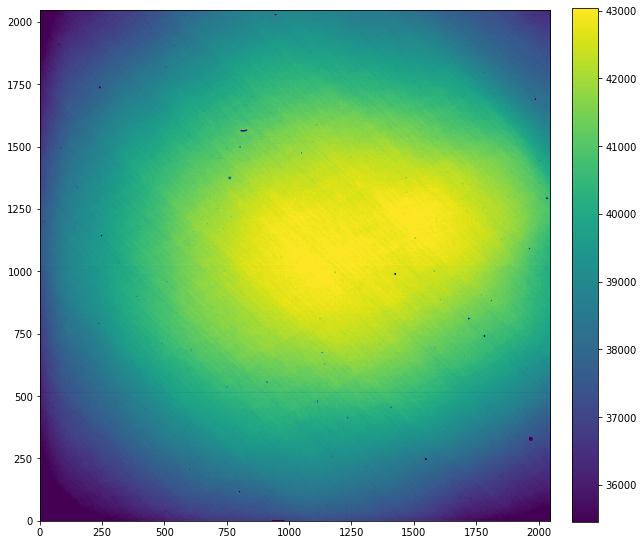

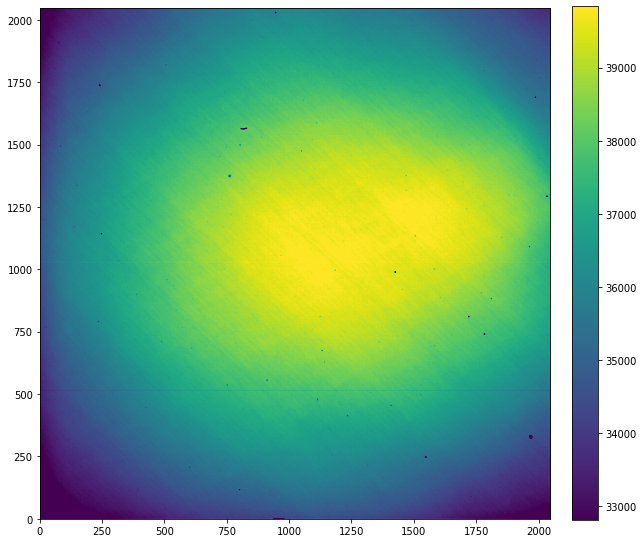

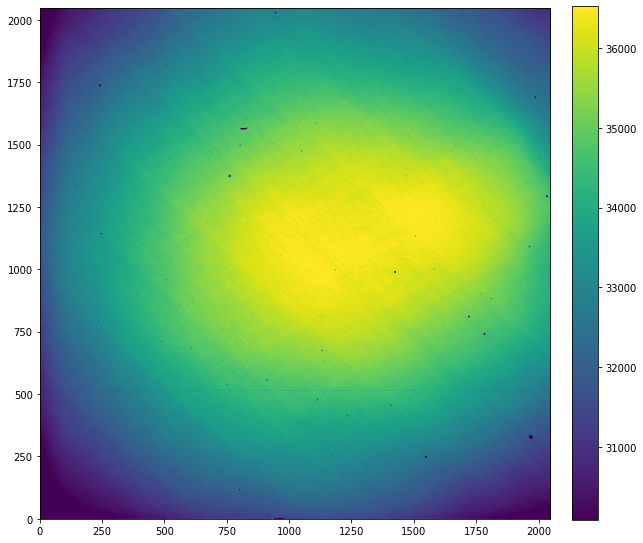

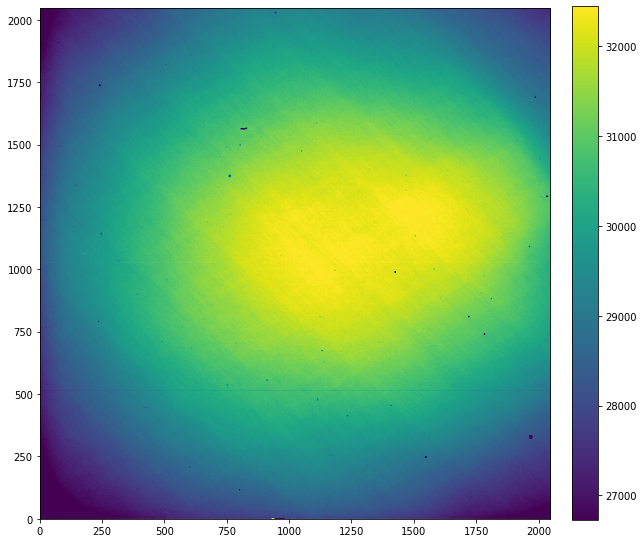

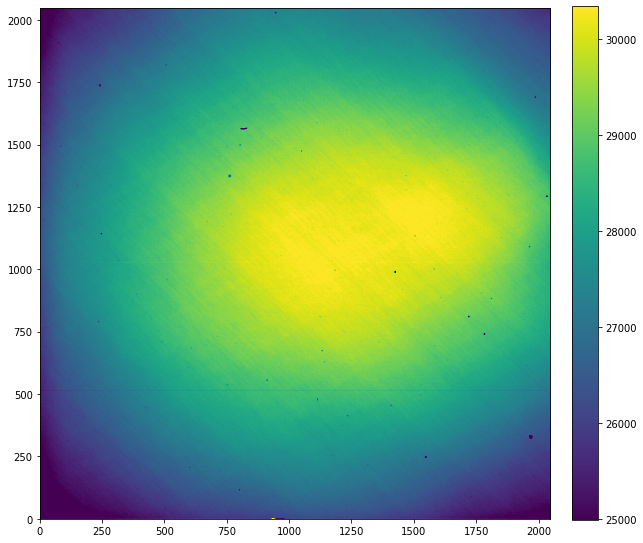

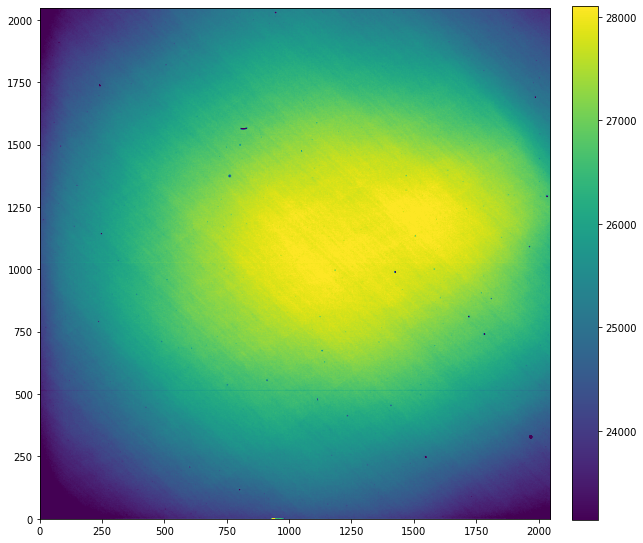

In [5]:
# Examine Flat field images
for i in range(num_flats):
    show_image(flat_images_ot[i])

<font color='red'>There are a few significant artifacts in each image. </font>

How might we combine the frames into a master flat field frame to get rid of these artifacts?

<font color='red'>We would want some kind of a scaled median combine that can reject pixels that are outliers</font>

Compare the average light levels in your V flats and say how this will impact your combine strategy

Image 0 mean value is 39840.3
Image 1 mean value is 36878.0
Image 2 mean value is 33810.0
Image 3 mean value is 30033.0
Image 4 mean value is 28086.5
Image 5 mean value is 26005.0


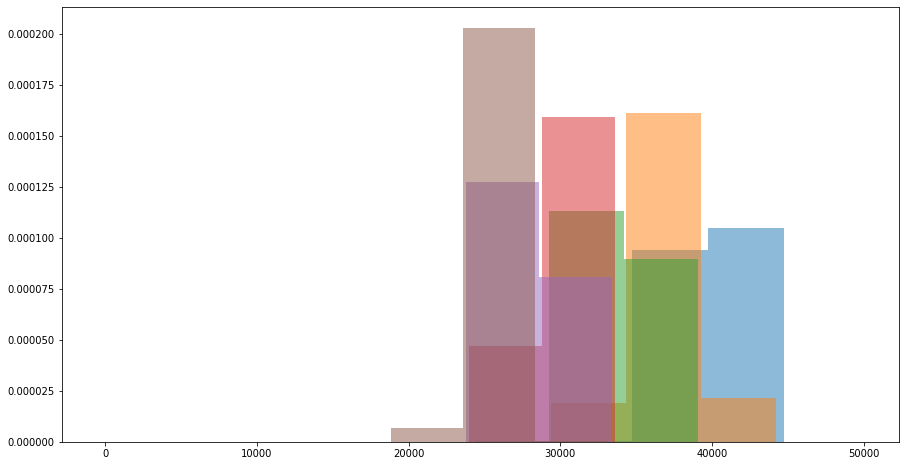

In [6]:
for i in range(num_flats):
    print("Image {:.0f} mean value is {:.1f}".format(i,np.mean(flat_images_ot[i,:,:])))
    plt.hist(flat_images_ot[i,:,:].flatten(),density=True,alpha=0.5)

<font color='red'>Because the image mean value changes significantly across flat images, we will want to scale all of our images onto a common mean (of 1) before combining</font>

Image 0 mean value is 1.0
Image 1 mean value is 1.0
Image 2 mean value is 1.0
Image 3 mean value is 1.0
Image 4 mean value is 1.0
Image 5 mean value is 1.0


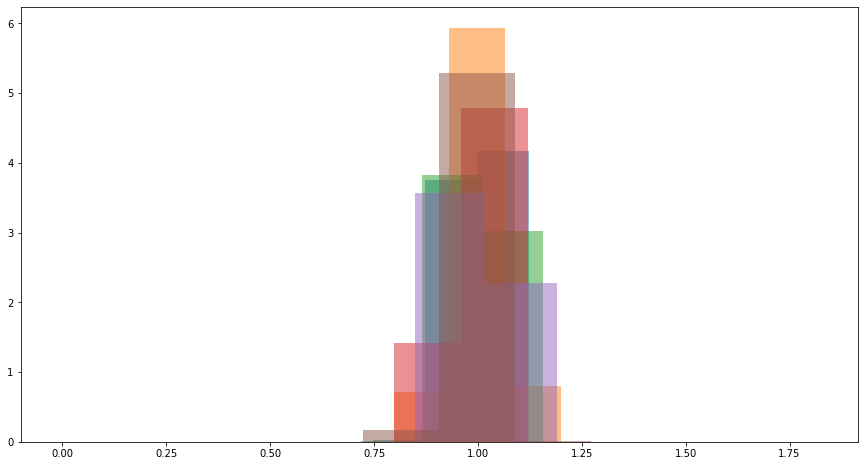

In [7]:
# Scale to a common mean
flat_images_ot_scaled=scaling(flat_images_ot,method='mean')

for i in range(num_flats):
    print("Image {:.0f} mean value is {:.1f}".format(i,np.mean(flat_images_ot_scaled[i,:,:])))
    plt.hist(flat_images_ot_scaled[i,:,:].flatten(),density=True,alpha=0.5)

discuss the advantages and disadvantages of making a master flat field image from:
 - A straight average of all V flat frames
 - A straight median of all V flat frames
 - An average where outlier pixels are rejected if they are more than 3σ from the mean
 - An average where outlier pixels are rejected and the weighted mean is obtained by weighting each image by the mean counts in the original image. This way, bright flats field exposures with higher count rates are given more weight than flats with low light levels.

Text(0.5, 1.0, 'Straight Average Combine')

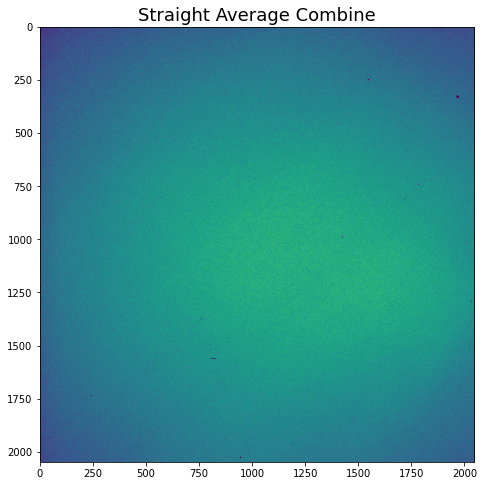

In [43]:
# A straight average of all scaled flat frames
flat_master_average=np.mean(flat_images_ot_scaled,axis=0)
#show_image(flat_master_average)
plt.imshow(flat_master_average,vmin=flat_scaled_vmin,vmax=flat_scaled_vmax)
plt.title('Straight Average Combine',fontsize=18)

Text(0.5, 1.0, 'Straight Median Combine')

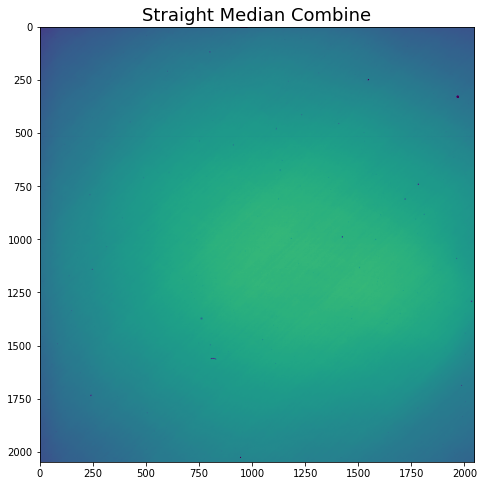

In [44]:
# A straight median of all scaled V flat frames
flat_master_median=np.median(flat_images_ot_scaled,axis=0)
#show_image(flat_master_median)
plt.imshow(flat_master_median,vmin=flat_scaled_vmin,vmax=flat_scaled_vmax)
plt.title('Straight Median Combine',fontsize=18)

In [14]:
# An average where outlier pixels are rejected if they are more than 3σ from the mean
# A 3 sigma cut does not remove any pixels, trying a 2 sigma cut instead
# NOTE expensive cell here
clipped_flats,mask=sigma_clip(flat_images_ot_scaled,N=2,method='mean')

Starting Sigma-Clip Iteration 1
Starting Sigma-Clip Iteration 2
Clipped 1.6 percent of pixels


Text(0.5, 1.0, 'Sigma-Clipped Average Combine')

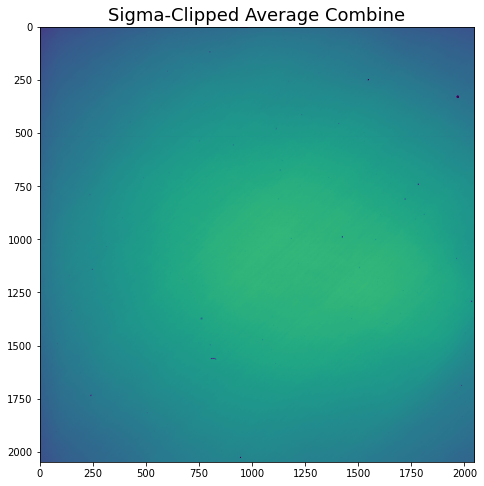

In [45]:
# create a masked array that reflects the mask from sigma clipping
# the mask I created has True for kept pixels
# numpy masked arrays have True for removed pixels
# which is why I invert mask
masked_array=np.ma.array(flat_images_ot_scaled,mask=np.invert(mask))
flat_master_average_clipped=np.ma.mean(masked_array,axis=0)
plt.imshow(flat_master_average_clipped,vmin=flat_scaled_vmin,vmax=flat_scaled_vmax)
plt.title('Sigma-Clipped Average Combine',fontsize=18)

Text(0.5, 1.0, 'Sigma-Clipped Weighted Average Combine')

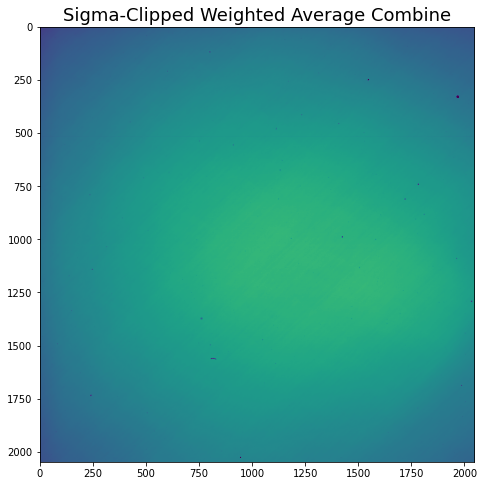

In [46]:
# An average where outlier pixels are rejected and the weighted mean is obtained by 
# weighting each image by the mean counts in the original image. 
# This way, bright flats field exposures with higher count rates are 
# given more weight than flats with low light levels.

flat_master_weighted_average_clipped=weighted_mean(flat_images_ot,mask=mask,combine_method='mean')
#show_image(flat_master_weighted_average_clipped)
plt.imshow(flat_master_weighted_average_clipped,vmin=flat_scaled_vmin,vmax=flat_scaled_vmax)
plt.title('Sigma-Clipped Weighted Average Combine',fontsize=18)

Text(0.5, 1.0, 'Sigma-Clipped Median Combine')

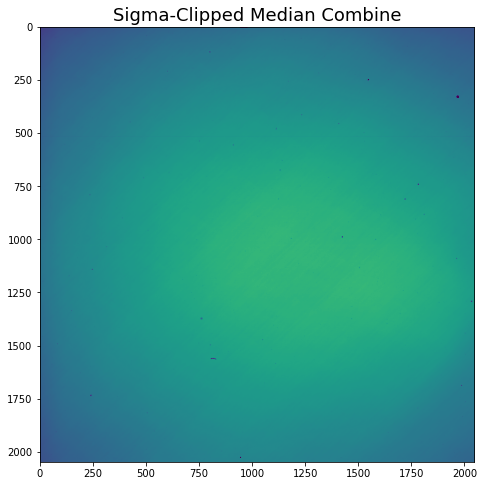

In [48]:
# What about a sigma-clipped median combine?
flat_master_median_clipped=weighted_mean(flat_images_ot,mask=mask,combine_method='median')
#show_image(flat_master_median_clipped)
plt.imshow(flat_master_median_clipped,vmin=flat_scaled_vmin,vmax=flat_scaled_vmax)
plt.title('Sigma-Clipped Median Combine',fontsize=18)

In [49]:
stddev_master_average=np.std(flat_master_average.flatten())
stddev_master_median=np.std(flat_master_median.flatten())
stddev_master_average_clipped=np.ma.std(flat_master_average_clipped.flatten())
stddev_master_median_clipped=np.ma.std(flat_master_median_clipped.flatten())
stddev_master_weighted_average_clipped=np.ma.std(flat_master_weighted_average_clipped.flatten())

print("Std. dev. for straight average combine: {:.7f}".format(stddev_master_average))
print("Std. dev. for straight median combine: {:.7f}".format(stddev_master_median))
print("Std. dev. for clipped average combine: {:.7f}".format(stddev_master_average_clipped))
print("Std. dev. for clipped median combine: {:.7f}".format(stddev_master_median_clipped))
print("Std. dev. for clipped weighted average combine: {:.7f}".format(stddev_master_weighted_average_clipped))

Std. dev. for straight average combine: 0.0698404
Std. dev. for straight median combine: 0.0497964
Std. dev. for clipped average combine: 0.0497571
Std. dev. for clipped median combine: 0.0497973
Std. dev. for clipped weighted average combine: 0.0497600


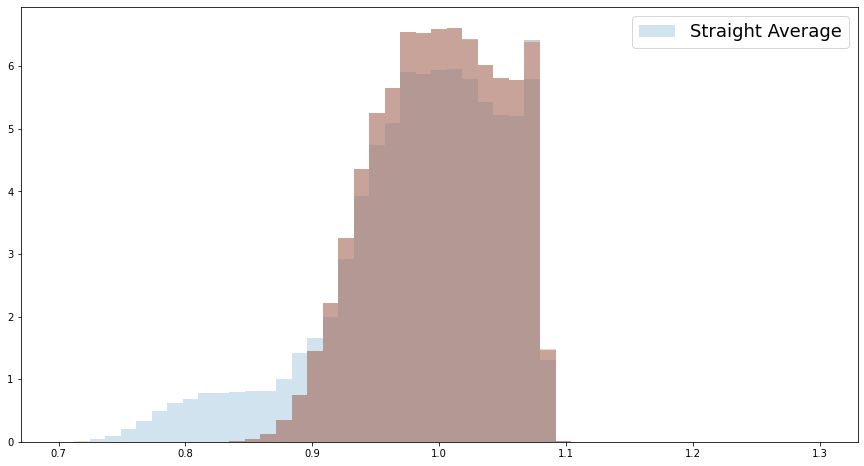

In [51]:
bins=np.linspace(0.7,1.3,num=50)
alpha=0.2
_,_,_=plt.hist(flat_master_average.flatten(),alpha=alpha,bins=bins,density=True,label='Straight Average')
_,_,_=plt.hist(flat_master_median.flatten(),alpha=alpha,bins=bins,density=True)
_,_,_=plt.hist(flat_master_average_clipped.flatten(),alpha=alpha,bins=bins,density=True)
_,_,_=plt.hist(flat_master_median_clipped.flatten(),alpha=alpha,bins=bins,density=True)
_,_,_=plt.hist(flat_master_weighted_average_clipped.flatten(),alpha=alpha,bins=bins,density=True)
plt.legend(loc='best',fontsize=18)

<font color='red'>The straight average combine is weighed down by outliers in the lower tail. Apart from that, it is nearly impossible to differentiate between the different methods</font>

## 2. 

Combine your flat field images to make a master flat for all filters using the strategy that you arrived at above.

In [63]:
flat_master=flat_master_median

## 3.

Normalize your master flat field image for each filter so that it has a mean of 1 (i.e., find the mean in the image and divide by that mean) This way, when you divide your images by your master flat field image, you don’t lose track of your photon statistics.

In [64]:
print(np.mean(flat_master))

0.9999524750264045


## 4.

Divide all your science frames by your normalized flat field.

In [57]:
# First subtract overscan and trim
science_images_ot=np.zeros(shape=(num_science,num_rows,num_columns_trim))
count=0
for name in sciencenames:
    data=fits.open(imagedir+name)[0].data
    science_ot,AIC=overscan_subtraction(data,right_overscan,trimsec,overscan_combine,fit_type,fit_deg)
    science_images_ot[count,:,:]=science_ot
    count+=1

In [58]:
# Now divide science frames by normalized flat field
science_images_otf=np.zeros(shape=(num_science,num_rows,num_columns_trim))
for i in range(num_science):
    science_images_otf[i,:,:]=science_images_ot[i,:,:]/flat_master

## 5.

Compute the gain and read noise for this CCD using a couple of the flat field images and bias images, as described in Howell’s Handbook of CCD Astronomy and in class notes. Decide, by examination, what sections of each image you should use to determine these values (using the whole frame is probably not a good idea, why?). NOTE: The flat-field images, F, that are used for this procedure should already be flat-fielded using a normalized master flat. Otherwise, the sigma term will contain contributions both from Poisson noise AND from pixel-to-pixel sensitivity fluctuations, and be too large, leading to an unrealistically small gain.

$$ Gain=\frac{(\bar{F_1}-\bar{F_2})-(\bar{B_1}-\bar{B_2})}{\sigma^2_{F_1-F_2}-\sigma^2_{B_1-B_2} } $$

$$ read \: noise= \frac{ G \: \sigma_{B_1-B_2} }{\sqrt{2}}$$

In [257]:
#get trimmed flat images
flat1=flat_images_ot[0,:,:].astype(np.float)
flat2=flat_images_ot[1,:,:].astype(np.float)

# get trimmed bias images
data=fits.open(imagedir+biasnames[0])[0].data
bias1=data[:,trimsec[0]:trimsec[1]].astype(np.float)
data=fits.open(imagedir+biasnames[1])[0].data
bias2=data[:,trimsec[0]:trimsec[1]].astype(np.float)


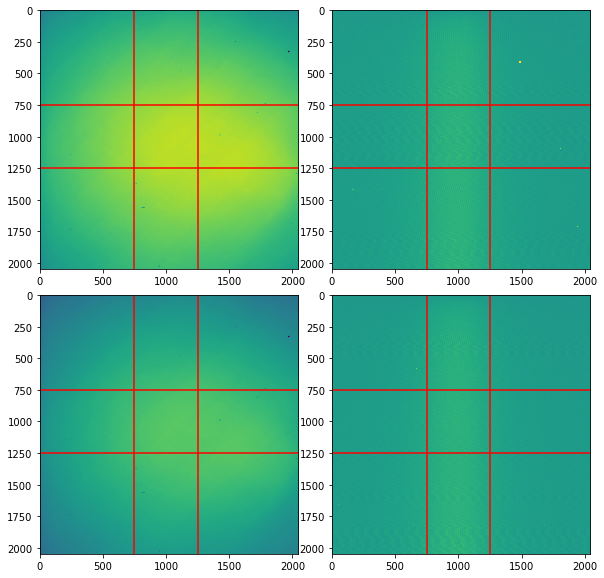

In [258]:
# Decide what sections of each image we should use

axis=[750,1250,750,1250]
rcParams['figure.figsize'] = 10,10
fig,axs=plt.subplots(nrows=2,ncols=2)
axs[0,0].imshow(flat1,vmin=flat_vmin,vmax=flat_vmax)
axs[0,0].axhline(axis[0],c='r')
axs[0,0].axhline(axis[1],c='r')
axs[0,0].axvline(axis[2],c='r')
axs[0,0].axvline(axis[3],c='r')

axs[1,0].imshow(flat2,vmin=flat_vmin,vmax=flat_vmax)
axs[1,0].axhline(axis[0],c='r')
axs[1,0].axhline(axis[1],c='r')
axs[1,0].axvline(axis[2],c='r')
axs[1,0].axvline(axis[3],c='r')

axs[0,1].imshow(bias1,vmin=bias_vmin,vmax=bias_vmax)
axs[0,1].axhline(axis[0],c='r')
axs[0,1].axhline(axis[1],c='r')
axs[0,1].axvline(axis[2],c='r')
axs[0,1].axvline(axis[3],c='r')

axs[1,1].imshow(bias2,vmin=bias_vmin,vmax=bias_vmax)
axs[1,1].axhline(axis[0],c='r')
axs[1,1].axhline(axis[1],c='r')
axs[1,1].axvline(axis[2],c='r')
axs[1,1].axvline(axis[3],c='r')

plt.subplots_adjust(wspace=0.1,hspace=0.1)

In [259]:
def get_gain_and_read_noise(flat1,flat2,master_flat,bias1,bias2,axis):
    '''
    
    params:
        flat1 - first flat image (trimmed and overscan subtracted)
        flat2 - second flat image (trimmed and overscan subtracted)
        master_flat - master flat image (created from trimmed and overscan subtracted flats)
        bias1 - first bias image (trimmed)
        bias2 - second bias image (trimmed)
        axis - [minrow,maxrow,mincol,maxcol] to use for each image
    '''
    
    # flat field flat images with master flat
    flat1=flat1/master_flat
    flat2=flat2/master_flat
    
    # chop off unwanted parts of the image
    flat1=flat1[axis[0]:axis[1],axis[2]:axis[3]]
    flat2=flat2[axis[0]:axis[1],axis[2]:axis[3]]
    bias1=bias1[axis[0]:axis[1],axis[2]:axis[3]]
    bias2=bias2[axis[0]:axis[1],axis[2]:axis[3]]
    
    F1_bar=np.mean(flat1.flatten())
    F2_bar=np.mean(flat2.flatten())
    B1_bar=np.mean(bias1.flatten())
    B2_bar=np.mean(bias2.flatten())
    
    flat_diff=flat1-flat2
    bias_diff=bias1-bias2
    
    sigmaF=np.std(flat_diff.flatten())
    sigmaB=np.std(bias_diff.flatten())
    
    G=((F1_bar-F2_bar)-(B1_bar-B2_bar))/(sigmaF**2-sigmaB**2)
    
    readnoise=G*sigmaB/np.sqrt(2)
    
    return G,readnoise
    

In [260]:
gain,readnoise=get_gain_and_read_noise(flat1,flat2,flat_master,bias1,bias2,axis)

print('Gain: {:.1f} e- ADU^-1'.format(gain))
print('Read Noise: {:.1f} photons pixel^-1'.format(readnoise))

Gain: 0.1 e- ADU^-1
Read Noise: 0.6 photons pixel^-1
